# training pytorch rnn

## 事前準備

In [1]:
!pip install torchinfo -q

In [2]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astrop

In [3]:
import torch

torch.__version__

'2.6.0+cu124'

In [4]:
# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## RNN

In [5]:
# @title 訓練データ用意(sinカーブ)
# sinカーブに乱数ノイズを加えたものを時系列データとし、訓練に使用する
import math
import torch
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2 * math.pi, 2 * math.pi, 100)
sin_y = torch.sin(sin_x) + 0.1 * torch.randn(len(sin_x))

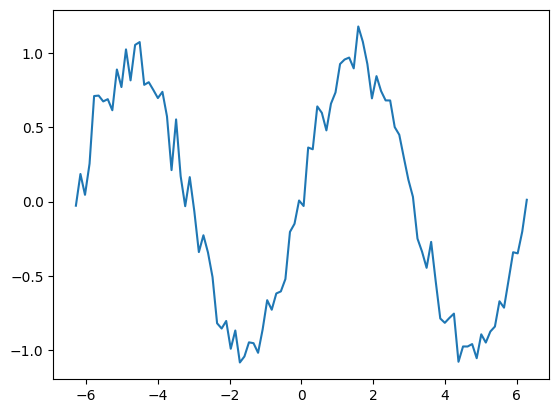

In [6]:
plt.plot(sin_x, sin_y)
plt.show()

In [7]:
# @title データ前処理
# 10個の値を入力データとし、その一つ後ろのデータを正解データとする
from torch.utils.data import TensorDataset, DataLoader

n_time = 10                     # 時系列データ幅
n_sample = len(sin_x) - n_time  # サンプル数

input_data = torch.zeros((n_sample, n_time, 1))
target_data = torch.zeros((n_sample, 1))

for i in range(n_sample):
    input_data[i] = sin_y[i:i + n_time].view(-1, 1)         # 入力データ：(時刻の数, 入力の数)
    target_data[i] = sin_y[i + n_time:i + n_time + 1]       # 正解データ：入力データの一つ後ろのデータ

In [8]:
input_data.shape, target_data.shape

(torch.Size([90, 10, 1]), torch.Size([90, 1]))

In [9]:
# @title DataLoader作成
n_batch = 8

dataset = TensorDataset(input_data, target_data)
train_loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

In [10]:
# @title モデル構築
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # NOTE: batch_first=True の場合、入力の形状は(バッチサイズ, 時刻の数, 入力の数)、
        #       batch_first=False の場合、入力の形状は(時刻の数、バッチサイズ, 入力の数)に設定する
        self.rnn = nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_rnn, h = self.rnn(x)
        y = self.fc(y_rnn[:, -1, :])       # -1で最後の時刻のみ取得し、全結合層に渡す
        return y

In [11]:
net = Net()

In [12]:
import torchinfo

torchinfo.summary(net, input_size=(8, 10, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [8, 1]                    --
├─RNN: 1-1                               [8, 10, 64]               4,288
├─Linear: 1-2                            [8, 1]                    65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.06

epoch: 1, loss_train: 0.4508


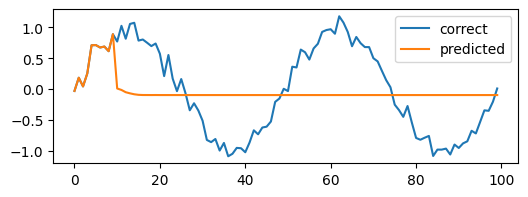

epoch: 11, loss_train: 0.0450


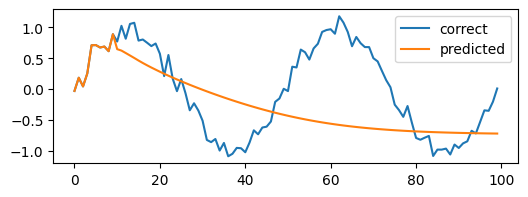

epoch: 21, loss_train: 0.0264


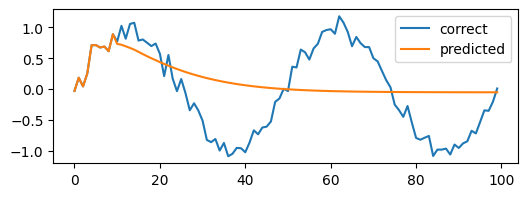

epoch: 31, loss_train: 0.0176


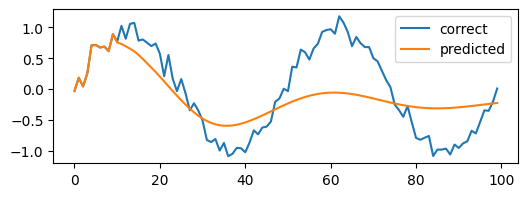

epoch: 41, loss_train: 0.0159


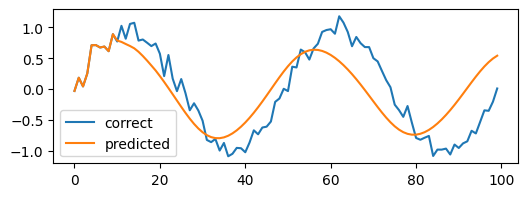

epoch: 51, loss_train: 0.0160


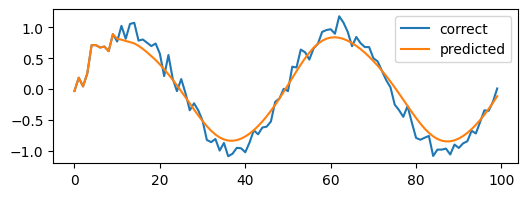

epoch: 61, loss_train: 0.0182


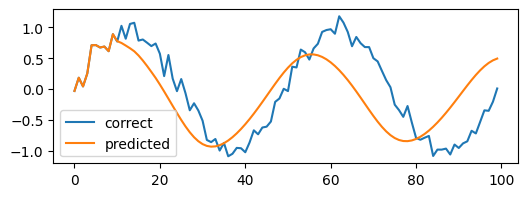

epoch: 71, loss_train: 0.0160


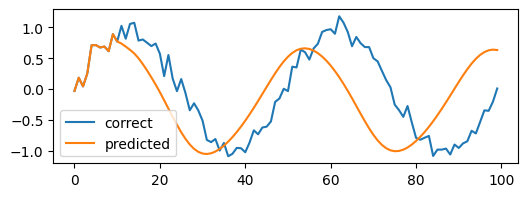

epoch: 81, loss_train: 0.0162


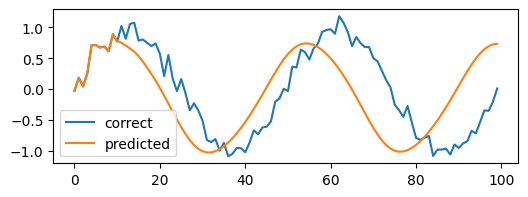

epoch: 91, loss_train: 0.0172


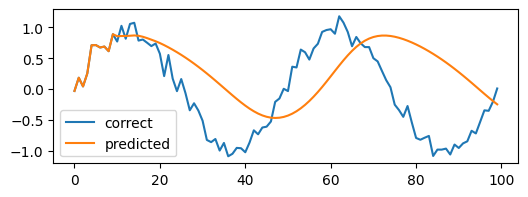

epoch: 100, loss_train: 0.0154


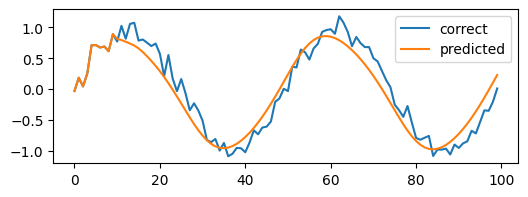

In [13]:
# @title 学習
from torch import optim

loss_func = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

record_loss_train = []

n_epochs = 100
verbose = 10


def verbose_process(epoch: int, loss_train: float) -> None:
    global net, n_time, n_sample, input_data
    # 進捗表示
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}')

    # 予測を実施
    net.eval()
    predicted = list(input_data[0].view(-1))    # 最初の入力

    for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:])   # 直近の時系列を取り出す
        x = x.view(1, n_time, 1)                # 変形:(バッチサイズ、時刻の数、入力の数)
        y = net(x)
        predicted.append(y[0].item())           # 予測結果を格納

    # 予測結果の描画
    plt.figure(figsize=(6, 2))
    plt.plot(range(len(sin_y)), sin_y, label="correct")
    plt.plot(range(len(predicted)), predicted, label="predicted")
    plt.legend()
    plt.show()


for epoch in range(n_epochs):
    net.train()
    loss_train = 0

    for j, (x, t) in enumerate(train_loader):
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    if epoch % verbose == 0 or epoch == n_epochs - 1:
        verbose_process(epoch, loss_train)

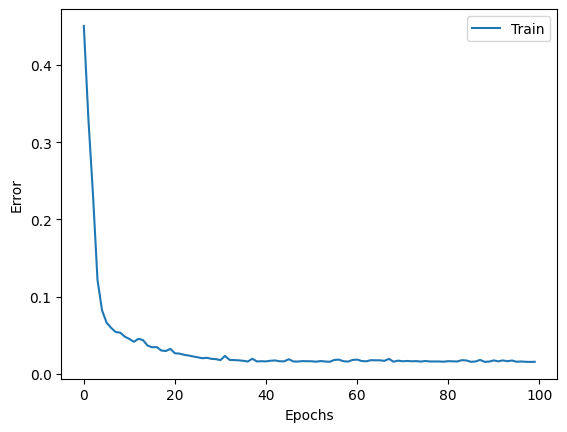

In [14]:
# @title 誤差の推移
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## LSTM

In [15]:
# @title 訓練データ用意(sinカーブ)
# sinカーブに乱数ノイズを加えたものを時系列データとし、訓練に使用する
import math
import torch
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2 * math.pi, 2 * math.pi, 100)
sin_y = torch.sin(sin_x) + 0.1 * torch.randn(len(sin_x))

In [16]:
# @title データ前処理
# 10個の値を入力データとし、その一つ後ろのデータを正解データとする
from torch.utils.data import TensorDataset, DataLoader

n_time = 10                     # 時系列データ幅
n_sample = len(sin_x) - n_time  # サンプル数

input_data = torch.zeros((n_sample, n_time, 1))
target_data = torch.zeros((n_sample, 1))

for i in range(n_sample):
    input_data[i] = sin_y[i:i + n_time].view(-1, 1)         # 入力データ：(時刻の数, 入力の数)
    target_data[i] = sin_y[i + n_time:i + n_time + 1]       # 正解データ：入力データの一つ後ろのデータ

In [17]:
# @title DataLoader作成
n_batch = 8

dataset = TensorDataset(input_data, target_data)
train_loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

In [18]:
# @title モデル構築
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_rnn, (h, c) = self.rnn(x, None)   # h:中間層の最終時刻の値、c:記憶セル
        y = self.fc(y_rnn[:, -1, :])        # -1で最後の時刻のみ取得し、全結合層に渡す
        return y

In [19]:
net = Net()

In [20]:
import torchinfo

torchinfo.summary(net, input_size=(8, 10, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [8, 1]                    --
├─LSTM: 1-1                              [8, 10, 64]               17,152
├─Linear: 1-2                            [8, 1]                    65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.07
Estimated Total Size (MB): 0.11

epoch: 1, loss_train: 0.2748


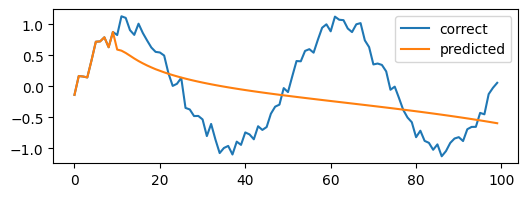

epoch: 11, loss_train: 0.0267


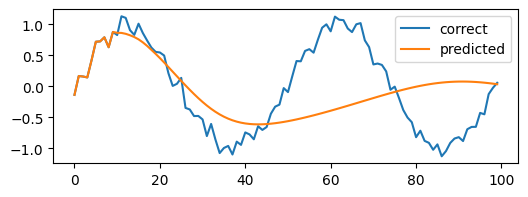

epoch: 21, loss_train: 0.0184


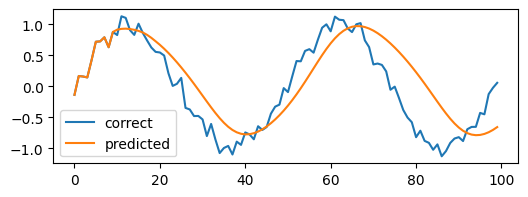

epoch: 31, loss_train: 0.0184


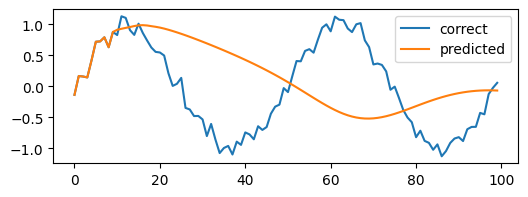

epoch: 41, loss_train: 0.0150


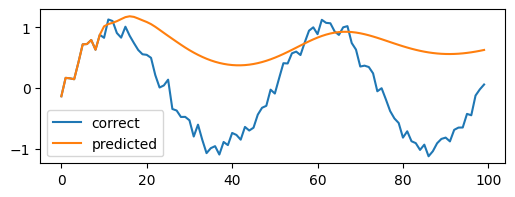

epoch: 51, loss_train: 0.0158


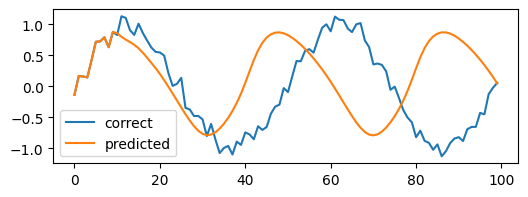

epoch: 61, loss_train: 0.0177


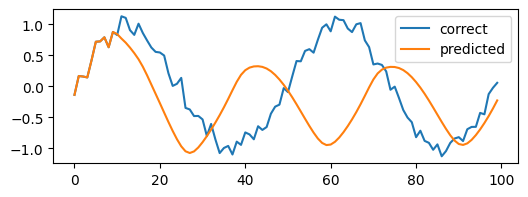

epoch: 71, loss_train: 0.0194


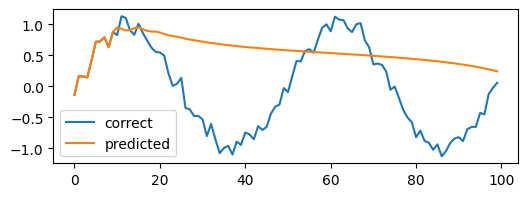

epoch: 81, loss_train: 0.0129


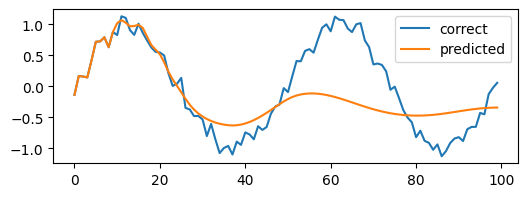

epoch: 91, loss_train: 0.0154


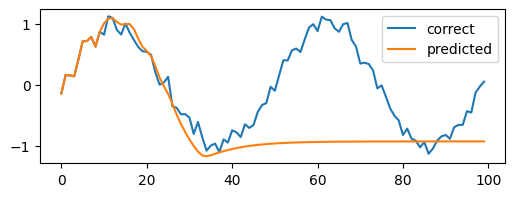

epoch: 100, loss_train: 0.0119


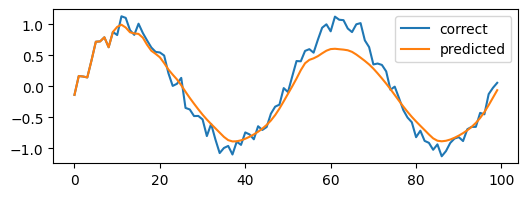

In [21]:
# @title 学習
from torch import optim

loss_func = nn.MSELoss()

# SGDだとうまく収束しなかったのでAdamに差し替え
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.01)

record_loss_train = []

n_epochs = 100
verbose = 10


def verbose_process(epoch: int, loss_train: float) -> None:
    global net, n_time, n_sample, input_data
    # 進捗表示
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}')

    # 予測を実施
    net.eval()
    predicted = list(input_data[0].view(-1))    # 最初の入力

    for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:])   # 直近の時系列を取り出す
        x = x.view(1, n_time, 1)                # 変形:(バッチサイズ、時刻の数、入力の数)
        y = net(x)
        predicted.append(y[0].item())           # 予測結果を格納

    # 予測結果の描画
    plt.figure(figsize=(6, 2))
    plt.plot(range(len(sin_y)), sin_y, label="correct")
    plt.plot(range(len(predicted)), predicted, label="predicted")
    plt.legend()
    plt.show()


for epoch in range(n_epochs):
    net.train()
    loss_train = 0

    for j, (x, t) in enumerate(train_loader):
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    if epoch % verbose == 0 or epoch == n_epochs - 1:
        verbose_process(epoch, loss_train)

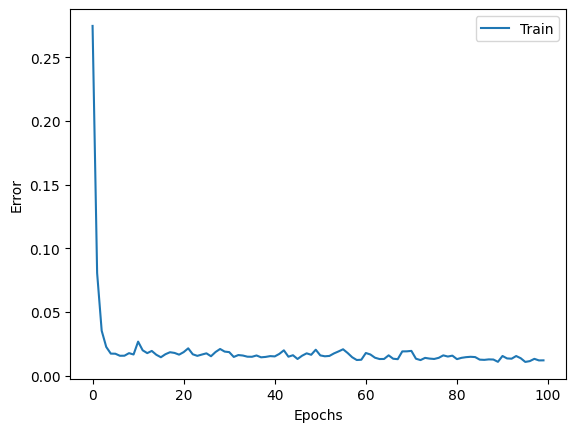

In [22]:
# @title 誤差の推移
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## GRU

In [35]:
# @title 訓練データ用意(sinカーブ)
# sinカーブに乱数ノイズを加えたものを時系列データとし、訓練に使用する
import math
import torch
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2 * math.pi, 2 * math.pi, 100)
sin_y = torch.sin(sin_x) + 0.1 * torch.randn(len(sin_x))

In [36]:
# @title データ前処理
# 10個の値を入力データとし、その一つ後ろのデータを正解データとする
from torch.utils.data import TensorDataset, DataLoader

n_time = 10                     # 時系列データ幅
n_sample = len(sin_x) - n_time  # サンプル数

input_data = torch.zeros((n_sample, n_time, 1))
target_data = torch.zeros((n_sample, 1))

for i in range(n_sample):
    input_data[i] = sin_y[i:i + n_time].view(-1, 1)         # 入力データ：(時刻の数, 入力の数)
    target_data[i] = sin_y[i + n_time:i + n_time + 1]       # 正解データ：入力データの一つ後ろのデータ

In [37]:
# @title DataLoader作成
n_batch = 8

dataset = TensorDataset(input_data, target_data)
train_loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

In [38]:
# @title モデル構築
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_rnn, h = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])        # -1で最後の時刻のみ取得し、全結合層に渡す
        return y

In [39]:
net = Net()

In [40]:
import torchinfo

torchinfo.summary(net, input_size=(8, 10, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [8, 1]                    --
├─GRU: 1-1                               [8, 10, 64]               12,864
├─Linear: 1-2                            [8, 1]                    65
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.05
Estimated Total Size (MB): 0.09

epoch: 1, loss_train: 0.1718


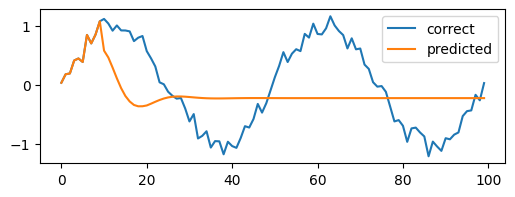

epoch: 11, loss_train: 0.0220


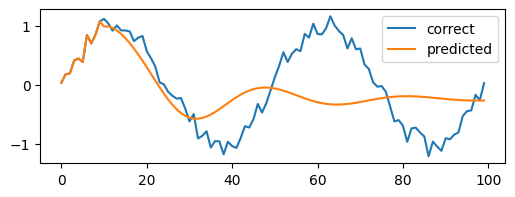

epoch: 21, loss_train: 0.0272


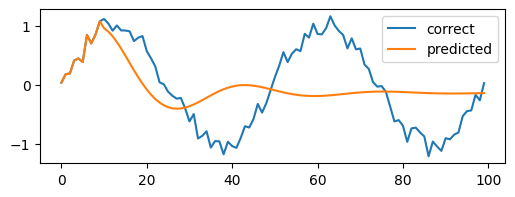

epoch: 31, loss_train: 0.0179


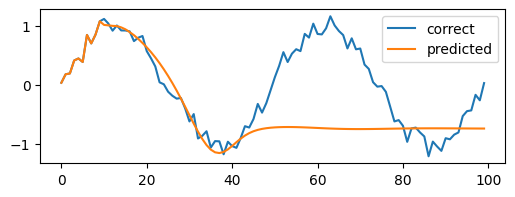

epoch: 41, loss_train: 0.0213


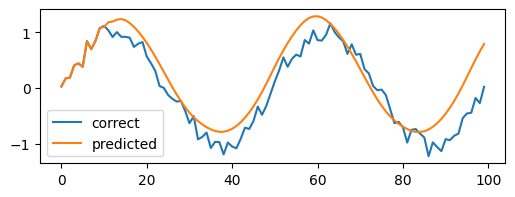

epoch: 51, loss_train: 0.0262


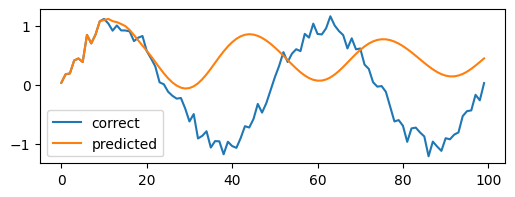

epoch: 61, loss_train: 0.0200


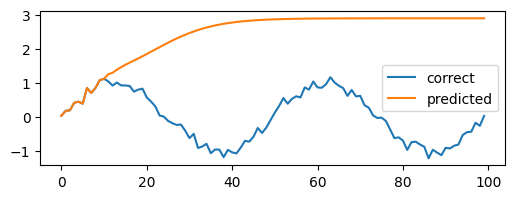

epoch: 71, loss_train: 0.0220


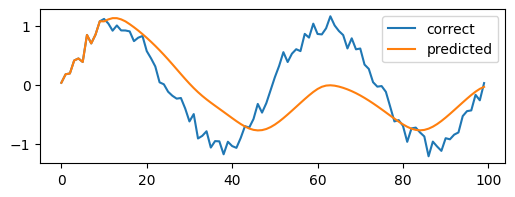

epoch: 81, loss_train: 0.0168


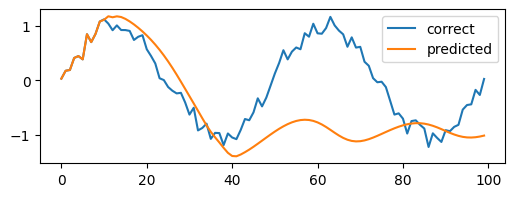

epoch: 91, loss_train: 0.0140


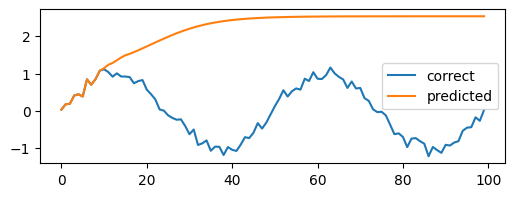

epoch: 100, loss_train: 0.0110


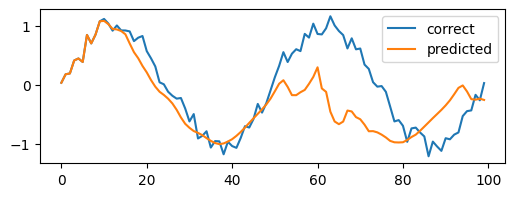

In [41]:
# @title 学習
from torch import optim

loss_func = nn.MSELoss()

# SGDだとうまく収束しなかったのでAdamに差し替え
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.01)

record_loss_train = []

n_epochs = 100
verbose = 10


def verbose_process(epoch: int, loss_train: float) -> None:
    global net, n_time, n_sample, input_data
    # 進捗表示
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}')

    # 予測を実施
    net.eval()
    predicted = list(input_data[0].view(-1))    # 最初の入力

    for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:])   # 直近の時系列を取り出す
        x = x.view(1, n_time, 1)                # 変形:(バッチサイズ、時刻の数、入力の数)
        y = net(x)
        predicted.append(y[0].item())           # 予測結果を格納

    # 予測結果の描画
    plt.figure(figsize=(6, 2))
    plt.plot(range(len(sin_y)), sin_y, label="correct")
    plt.plot(range(len(predicted)), predicted, label="predicted")
    plt.legend()
    plt.show()


for epoch in range(n_epochs):
    net.train()
    loss_train = 0

    for j, (x, t) in enumerate(train_loader):
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    if epoch % verbose == 0 or epoch == n_epochs - 1:
        verbose_process(epoch, loss_train)

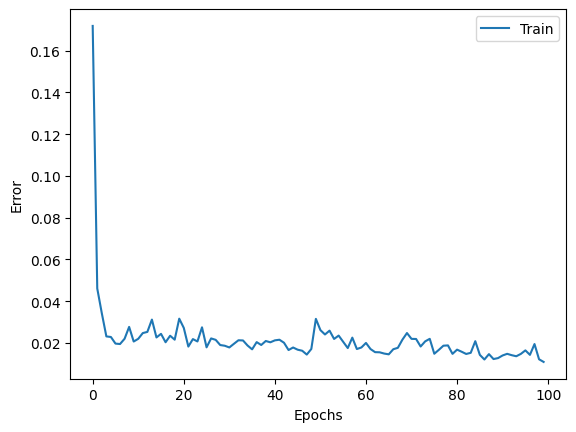

In [42]:
# @title 誤差の推移
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()